In [1]:
from unet import unet
from res_unet import res_unet
from UNetPlusPlus.segmentation_models import Xnet
from data import *
from matplotlib import pyplot as plt
from random import randrange
# from sklearn.metrics import precision_score, roc_curve
import os
import h5py
import pandas as pd

from keras.utils import plot_model

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

%matplotlib inline

Using TensorFlow backend.


In [2]:
input_shape = (128,128)

model_names = ['unet_bus_base_w_normals' , 'unet_bus_base_w_normals_aug', 
               'unet_bus_base+batchnorm_w_normals' , 'unet_bus_base+batchnorm_w_normals_aug',
               'res_unet_bus_base_w_normals' , 'res_unet_bus_base_w_normals_aug',
               'res_unet_bus_base+batchnorm_w_normals' , 'res_unet_bus_base+batchnorm_w_normals_aug',
               'xnet_inceptionresnet_bb_bus_w_normals_noaug','xnet_inceptionresnet_bb_bus_w_normals_aug']

#unet with no augmentation w batchnorm
base_unet_no_aug = unet(batchnorm = False,input_size=input_shape+(1,))
base_unet_no_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[0]))
                              
#unet with w batchnorm
base_unet_aug = unet(batchnorm = False, input_size=input_shape+(1,))
base_unet_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[1]))
                           
#unet with no augmentation w batchnorm
unet_no_aug = unet(batchnorm = True, input_size=input_shape+(1,))
unet_no_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[2]))
                         
#unet with w batchnorm
unet_aug = unet(batchnorm = True, input_size=input_shape+(1,))
unet_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[3]))
     
#resunet with no augmentation without batchnorm
res_unet_no_bn_no_aug = res_unet(batchnorm = False,input_size=input_shape+(1,))
res_unet_no_bn_no_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[4]))
                             
#resunet with aug without batchnorm
res_unet_no_bn_aug = res_unet(batchnorm = False, input_size=input_shape+(1,))
res_unet_no_bn_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[5])) 
       
#resunet with no augmentation w batchnorm
res_unet_no_aug = res_unet(batchnorm = True, input_size=input_shape+(1,))
res_unet_no_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[6]))
                             
#resunet with aug w batchnorm
res_unet_aug = res_unet(batchnorm = True, input_size=input_shape+(1,))
res_unet_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[7]))

#res_unet_++ with no augmentation 
inception_res_unet_no_aug = Xnet(backbone_name='inceptionresnetv2', input_shape=input_shape+(1,), encoder_weights=None, decoder_block_type='transpose')
inception_res_unet_no_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[8]))
                             
#res_unet_++ with aug
inception_res_unet_aug = Xnet(backbone_name='inceptionresnetv2', input_shape=input_shape+(1,), encoder_weights=None, decoder_block_type='transpose')
inception_res_unet_aug.load_weights('models/unet_seg_models/{}.hdf5'.format(model_names[9]))
                          
seg_model = {model_names[0]:base_unet_no_aug,
             model_names[1]:base_unet_aug,
             model_names[2]:unet_no_aug,
             model_names[3]:unet_aug,
             model_names[4]:res_unet_no_bn_no_aug,
             model_names[5]:res_unet_no_bn_aug,
             model_names[6]:res_unet_no_aug,
             model_names[7]:res_unet_aug,
             model_names[8]:inception_res_unet_no_aug,
             model_names[9]:inception_res_unet_aug
}

In [3]:
# Validation set
path_to_val_images = 'data/seg_dir/val_images'
path_to_val_masks = 'data/seg_dir/val_masks'

# # Test set
# path_to_val_images = 'data/seg_dir_test_images'
# path_to_val_masks = 'data/seg_dir_test_masks'

In [4]:
smooth = 1 

overlayed_masks = []

#unet with no augmentation 
mean_iou_base_unet_no_aug = []
mean_dice_loss_base_unet_no_aug = []
mean_accuracy_base_unet_no_aug = []
mean_recall_base_unet_no_aug = []
mean_selectivity_base_unet_no_aug = []
mean_precision_base_unet_no_aug = []

preds_base_unet_no_aug = []

#unet with augmentation
mean_iou_base_unet_aug = []
mean_dice_loss_base_unet_aug = []
mean_accuracy_base_unet_aug = []
mean_recall_base_unet_aug = []
mean_selectivity_base_unet_aug = []
mean_precision_base_unet_aug = []

preds_base_unet_aug = []

#unet with no augmentation w batchnorm
mean_iou_unet_no_aug = []
mean_dice_loss_unet_no_aug = []
mean_accuracy_unet_no_aug = []
mean_recall_unet_no_aug = []
mean_selectivity_unet_no_aug = []
mean_precision_unet_no_aug = []

preds_unet_no_aug = []

#unet with augmentation w batchnorm
mean_iou_unet_aug = []
mean_dice_loss_unet_aug = []
mean_accuracy_unet_aug = []
mean_recall_unet_aug = []
mean_selectivity_unet_aug = []
mean_precision_unet_aug = []

preds_unet_aug = []

#resunet with no augmentation without batchnorm
mean_iou_res_unet_no_bn_no_aug = []
mean_dice_loss_res_unet_no_bn_no_aug = []
mean_accuracy_res_unet_no_bn_no_aug = []
mean_recall_res_unet_no_bn_no_aug = []
mean_selectivity_res_unet_no_bn_no_aug = []
mean_precision_res_unet_no_bn_no_aug = []

preds_res_unet_no_bn_no_aug = []

#resunet with augmentation without batchnorm
mean_iou_res_unet_no_bn_aug = []
mean_dice_loss_res_unet_no_bn_aug = []
mean_accuracy_res_unet_no_bn_aug = []
mean_recall_res_unet_no_bn_aug = []
mean_selectivity_res_unet_no_bn_aug = []
mean_precision_res_unet_no_bn_aug = []

preds_res_unet_no_bn_aug = []

#resunet with no augmentation w batchnormm
mean_iou_res_unet_no_aug = []
mean_dice_loss_res_unet_no_aug = []
mean_accuracy_res_unet_no_aug = []
mean_recall_res_unet_no_aug = []
mean_selectivity_res_unet_no_aug = []
mean_precision_res_unet_no_aug = []

preds_res_unet_no_aug = []

#resunet with augmentation w batchnorm
mean_iou_res_unet_aug = []
mean_dice_loss_res_unet_aug = []
mean_accuracy_res_unet_aug = []
mean_recall_res_unet_aug = []
mean_selectivity_res_unet_aug = []
mean_precision_res_unet_aug = []

preds_res_unet_aug = []

#res_unet_++ with no augmentation 
mean_iou_res_unet_pp_no_aug = []
mean_dice_loss_res_unet_pp_no_aug = []
mean_accuracy_res_unet_pp_no_aug = []
mean_recall_res_unet_pp_no_aug = []
mean_selectivity_res_unet_pp_no_aug = []
mean_precision_res_unet_pp_no_aug = []

preds_res_unet_pp_no_aug = []

#res_unet_pp with augmentation w batchnorm
mean_iou_res_unet_pp_aug = []
mean_dice_loss_res_unet_pp_aug = []
mean_accuracy_res_unet_pp_aug = []
mean_recall_res_unet_pp_aug = []
mean_selectivity_res_unet_pp_aug = []
mean_precision_res_unet_pp_aug = []

preds_res_unet_pp_aug = []


ious = [mean_iou_base_unet_no_aug, mean_iou_base_unet_aug,
        mean_iou_unet_no_aug, mean_iou_unet_aug,
        mean_iou_res_unet_no_bn_no_aug, mean_iou_res_unet_no_bn_aug,
        mean_iou_res_unet_no_aug, mean_iou_res_unet_aug,
        mean_iou_res_unet_pp_no_aug, mean_iou_res_unet_pp_aug]

dice_losses = [mean_dice_loss_base_unet_no_aug, mean_dice_loss_base_unet_aug,
               mean_dice_loss_unet_no_aug, mean_dice_loss_unet_aug,
               mean_dice_loss_res_unet_no_bn_no_aug, mean_dice_loss_res_unet_no_bn_aug,
               mean_dice_loss_res_unet_no_aug, mean_dice_loss_res_unet_aug,
               mean_dice_loss_res_unet_pp_no_aug, mean_dice_loss_res_unet_pp_aug]

accuracies = [mean_accuracy_base_unet_no_aug, mean_accuracy_base_unet_aug,
              mean_accuracy_unet_no_aug, mean_accuracy_unet_aug,
              mean_accuracy_res_unet_no_bn_no_aug, mean_accuracy_res_unet_no_bn_aug,
              mean_accuracy_res_unet_no_aug, mean_accuracy_res_unet_aug,
              mean_accuracy_res_unet_pp_no_aug, mean_accuracy_res_unet_pp_aug]

recalls = [mean_recall_base_unet_no_aug, mean_recall_base_unet_aug,
           mean_recall_unet_no_aug, mean_recall_unet_aug,
           mean_recall_res_unet_no_bn_no_aug, mean_recall_res_unet_no_bn_aug,           
           mean_recall_res_unet_no_aug, mean_recall_res_unet_aug,
           mean_recall_res_unet_pp_no_aug, mean_recall_res_unet_pp_aug]

selectivities = [mean_selectivity_base_unet_no_aug, mean_selectivity_base_unet_aug,
                 mean_selectivity_unet_no_aug, mean_selectivity_unet_aug,                
                 mean_selectivity_res_unet_no_bn_no_aug, mean_selectivity_res_unet_no_bn_aug,           
                 mean_selectivity_res_unet_no_aug, mean_selectivity_res_unet_aug,
                 mean_selectivity_res_unet_pp_no_aug, mean_selectivity_res_unet_pp_aug]

precisions = [mean_precision_base_unet_no_aug, mean_precision_base_unet_aug,
              mean_precision_unet_no_aug, mean_precision_unet_aug,
              mean_precision_res_unet_no_bn_no_aug, mean_precision_res_unet_no_bn_aug,           
              mean_precision_res_unet_no_aug, mean_precision_res_unet_aug,
              mean_precision_res_unet_pp_no_aug, mean_precision_res_unet_pp_aug]

preds = [preds_base_unet_no_aug, preds_base_unet_aug,
         preds_unet_no_aug, preds_unet_aug,
         preds_res_unet_no_bn_no_aug, preds_res_unet_no_bn_aug,           
         preds_res_unet_no_aug, preds_res_unet_aug,
         preds_res_unet_pp_no_aug, preds_res_unet_pp_aug]

for idx, image in enumerate(os.listdir(path_to_val_images)):
    print('idx :',idx)
    path_to_image = os.path.join(path_to_val_images,image)
    print('image :',path_to_image)
    #read in image
    img_or = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    #resize to shape injestible by model
    img_disp = cv2.resize(img_or, input_shape)
    #divide by 255 and add one dimension
    img = img_disp/255.0
    img = np.reshape(img,img.shape + (1,))
    
    path_to_mask = os.path.join(path_to_val_masks,image)
    #read in ground truth mask
    mask_or = cv2.imread(path_to_mask, cv2.IMREAD_GRAYSCALE)
    #map gt mask to binary mask
    mask = np.where(mask_or==255.0,1.0,0.0).astype(np.uint8)
    #resize
    mask = cv2.resize(mask, input_shape)
    #overlay gt mask over original image
    mask_disp = cv2.addWeighted(img_disp,1,np.where(mask==1,255,0).astype(np.uint8),1,0)
    overlayed_masks.append(mask_disp)
    
    for idx, model in enumerate(model_names):        
        ##predict with model##
        print('predict with--> ', model)
        trained_model = seg_model[model]
        pred_or = trained_model.predict(np.array([img]))[0,:,:,0]
        #map output to binary mask
        pred = np.where(pred_or>0.5,1.0,0.0)
        #overlay pred mask over original image
        pred_disp = cv2.addWeighted(img_disp,1,np.where(pred_or>0.5,255,0).astype(np.uint8),1,0)
        preds[idx].append(pred_disp)
        #metrics   
        tp = np.sum(mask.flatten()*pred.flatten())
        fp = np.sum((1-mask.flatten())*pred.flatten())
        fn = np.sum(mask.flatten()*(1-pred.flatten()))
        tn = np.sum((1-mask.flatten())*(1-pred.flatten()))
        iou = (tp+smooth)/(tp+fp+fn+smooth)
        dice_loss = (2*tp+smooth)/((2*tp)+fp+fn+smooth)
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        recall = (tp+smooth)/(tp+fn+smooth)
        selectivity = (tn+smooth)/(tn+fp+smooth)
        precision = (tp+smooth)/(tp+fp+smooth)
        print('iou :,',iou)
        print('dice loss:,',dice_loss)
        print('accuracy:,',accuracy)
        ious[idx].append(iou)
        dice_losses[idx].append(dice_loss)
        accuracies[idx].append(accuracy)
        recalls[idx].append(recall)
        selectivities[idx].append(selectivity)
        precisions[idx].append(precision)
        print('')
    print('****')

idx : 0
image : data/seg_dir/val_images/malignant (66).png
predict with-->  unet_bus_base_w_normals
iou :, 0.7290388548057259
dice loss:, 0.8431952662721893
accuracy:, 0.98382568359375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.8541666666666666
dice loss:, 0.9213041034288927
accuracy:, 0.991455078125

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.7626582278481012
dice loss:, 0.8652694610778443
accuracy:, 0.98626708984375

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.8216494845360824
dice loss:, 0.9020385050962627
accuracy:, 0.98944091796875

predict with-->  res_unet_bus_base_w_normals
iou :, 0.76440329218107
dice loss:, 0.8663943990665111
accuracy:, 0.98602294921875

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.7888324873096447
dice loss:, 0.881885292447473
accuracy:, 0.9873046875

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.680161943319838
dice loss:, 0.8095238095238095
accuracy:, 0.980712890625

predict wi

iou :, 0.8506493506493507
dice loss:, 0.9190140845070423
accuracy:, 0.99859619140625

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.8930817610062893
dice loss:, 0.9433333333333334
accuracy:, 0.99896240234375

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.8579881656804734
dice loss:, 0.9233226837060703
accuracy:, 0.99853515625

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.8662420382165605
dice loss:, 0.928082191780822
accuracy:, 0.99871826171875

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.8961038961038961
dice loss:, 0.9450171821305842
accuracy:, 0.9990234375

****
idx : 7
image : data/seg_dir/val_images/benign (400).png
predict with-->  unet_bus_base_w_normals
iou :, 0.894576477757465
dice loss:, 0.9443506232408524
accuracy:, 0.957763671875

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.8938121890547264
dice loss:, 0.9439244663382594
accuracy:, 0.95831298828125

predict with-->  unet_bus_b

iou :, 0.7073732718894009
dice loss:, 0.8284942606347063
accuracy:, 0.9844970703125

****
idx : 13
image : data/seg_dir/val_images/benign (356).png
predict with-->  unet_bus_base_w_normals
iou :, 0.935116004718836
dice loss:, 0.9664634146341463
accuracy:, 0.98992919921875

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.9119448698315467
dice loss:, 0.9539355097135991
accuracy:, 0.9859619140625

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.3498402555910543
dice loss:, 0.5182006510802012
accuracy:, 0.900634765625

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.9171206225680933
dice loss:, 0.9567600487210719
accuracy:, 0.98699951171875

predict with-->  res_unet_bus_base_w_normals
iou :, 0.9183592194344883
dice loss:, 0.9574335548172758
accuracy:, 0.98748779296875

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.9284317559640204
dice loss:, 0.9628803245436105
accuracy:, 0.98883056640625

predict with-->  res_unet_bus_base+batchnorm_w_normals

iou :, 0.8849162011173184
dice loss:, 0.938908659549229
accuracy:, 0.99371337890625

****
idx : 19
image : data/seg_dir/val_images/benign (165).png
predict with-->  unet_bus_base_w_normals
iou :, 0.2900552486187845
dice loss:, 0.44849785407725323
accuracy:, 0.98431396484375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.18450184501845018
dice loss:, 0.31045241809672386
accuracy:, 0.9730224609375

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.6581196581196581
dice loss:, 0.7927461139896373
accuracy:, 0.99755859375

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.6442953020134228
dice loss:, 0.7827868852459017
accuracy:, 0.99676513671875

predict with-->  res_unet_bus_base_w_normals
iou :, 0.6486486486486487
dice loss:, 0.7857142857142857
accuracy:, 0.99761962890625

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.6981132075471698
dice loss:, 0.8212290502793296
accuracy:, 0.998046875

predict with-->  res_unet_bus_base+batchnorm_w_normals
i

iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

****
idx : 26
image : data/seg_dir/val_images/malignant (188).png
predict with-->  unet_bus_base_w_normals
iou :, 0.7587287376902417
dice loss:, 0.8627800407331976
accuracy:, 0.96710205078125

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.7072129748186087
dice loss:, 0.8284571142785696
accuracy:, 0.9581298828125

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.7091531223267751
dice loss:, 0.8297872340425532
accuracy:, 0.95849609375

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.7492038216560509
dice loss:, 0

iou :, 0.6658348457350273
dice loss:, 0.7993734677199673
accuracy:, 0.91009521484375

****
idx : 32
image : data/seg_dir/val_images/malignant (139).png
predict with-->  unet_bus_base_w_normals
iou :, 0.9078758949880669
dice loss:, 0.9517017017017017
accuracy:, 0.98822021484375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.8441427853192559
dice loss:, 0.9154622307062994
accuracy:, 0.9810791015625

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.803921568627451
dice loss:, 0.891274045163089
accuracy:, 0.9761962890625

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.8370702541106129
dice loss:, 0.9112859468258274
accuracy:, 0.98004150390625

predict with-->  res_unet_bus_base_w_normals
iou :, 0.8530132288094071
dice loss:, 0.9206559111346204
accuracy:, 0.981689453125

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.8599412340842312
dice loss:, 0.9246773768764814
accuracy:, 0.9825439453125

predict with-->  res_unet_bus_base+batchnorm_w_normal

iou :, 0.8153153153153153
dice loss:, 0.8980099502487562
accuracy:, 0.99749755859375

****
idx : 38
image : data/seg_dir/val_images/benign (37).png
predict with-->  unet_bus_base_w_normals
iou :, 0.875
dice loss:, 0.9332129963898917
accuracy:, 0.99774169921875

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.8239202657807309
dice loss:, 0.9032846715328468
accuracy:, 0.99676513671875

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.7972972972972973
dice loss:, 0.8870056497175142
accuracy:, 0.996337890625

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.7793296089385475
dice loss:, 0.8757861635220126
accuracy:, 0.99517822265625

predict with-->  res_unet_bus_base_w_normals
iou :, 0.8614864864864865
dice loss:, 0.9254545454545454
accuracy:, 0.99749755859375

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.8434504792332268
dice loss:, 0.9149305555555556
accuracy:, 0.99700927734375

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.8

iou :, 0.43010752688172044
dice loss:, 0.6
accuracy:, 0.9935302734375

****
idx : 44
image : data/seg_dir/val_images/benign (399).png
predict with-->  unet_bus_base_w_normals
iou :, 0.8688796680497926
dice loss:, 0.9298245614035088
accuracy:, 0.980712890625

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.9060657118786858
dice loss:, 0.9507073386383731
accuracy:, 0.98638916015625

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.891396933560477
dice loss:, 0.9425675675675675
accuracy:, 0.98443603515625

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.8956849602010892
dice loss:, 0.9449602122015915
accuracy:, 0.98480224609375

predict with-->  res_unet_bus_base_w_normals
iou :, 0.8941126641253706
dice loss:, 0.9440840975173339
accuracy:, 0.9847412109375

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.8946280991735537
dice loss:, 0.944371727748691
accuracy:, 0.98443603515625

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.89451

iou :, 0.8056755089450957
dice loss:, 0.8923628908252178
accuracy:, 0.9615478515625

****
idx : 50
image : data/seg_dir/val_images/normal (81).png
predict with-->  unet_bus_base_w_normals
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.002173913043478261
dice loss:, 0.002173913043478261
accuracy:, 0.97198486328125

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base_w_normals
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
i

iou :, 0.6492048643592142
dice loss:, 0.7871736662883088
accuracy:, 0.97711181640625

****
idx : 56
image : data/seg_dir/val_images/benign (395).png
predict with-->  unet_bus_base_w_normals
iou :, 0.29024016351558507
dice loss:, 0.44968304278922344
accuracy:, 0.91522216796875

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.7293307086614174
dice loss:, 0.843438656419015
accuracy:, 0.9664306640625

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.2670807453416149
dice loss:, 0.4213322435635472
accuracy:, 0.91357421875

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.7997941327843541
dice loss:, 0.8887299771167048
accuracy:, 0.97625732421875

predict with-->  res_unet_bus_base_w_normals
iou :, 0.4224788982674367
dice loss:, 0.5938769134645423
accuracy:, 0.920654296875

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.7247845919918905
dice loss:, 0.8403880070546738
accuracy:, 0.96685791015625

predict with-->  res_unet_bus_base+batchnorm_w_normals

iou :, 0.06778087279480037
dice loss:, 0.12619669277632725
accuracy:, 0.938720703125

****
idx : 62
image : data/seg_dir/val_images/normal (68).png
predict with-->  unet_bus_base_w_normals
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  unet_bus_base_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base_w_normals
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

pred

iou :, 0.7017857142857142
dice loss:, 0.8245798319327731
accuracy:, 0.98980712890625

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.8312611012433393
dice loss:, 0.9077669902912622
accuracy:, 0.99420166015625

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.7370078740157481
dice loss:, 0.8484573502722323
accuracy:, 0.98980712890625

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.7888446215139442
dice loss:, 0.8818283166109253
accuracy:, 0.9935302734375

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.0020833333333333333
dice loss:, 0.0020833333333333333
accuracy:, 0.97076416015625

****
idx : 69
image : data/seg_dir/val_images/benign (347).png
predict with-->  unet_bus_base_w_normals
iou :, 0.7366666666666667
dice loss:, 0.8480769230769231
accuracy:, 0.99517822265625

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.7294520547945206
dice loss:, 0.8432539682539683
accuracy:, 0.99517822265625

predict wi

iou :, 0.8824821526633718
dice loss:, 0.937563822027717
accuracy:, 0.973876953125

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.8718851570964247
dice loss:, 0.9315484804630969
accuracy:, 0.97113037109375

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.861784140969163
dice loss:, 0.9257506286052359
accuracy:, 0.9693603515625

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.8438371444506414
dice loss:, 0.915292693994857
accuracy:, 0.9658203125

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.8865663322185061
dice loss:, 0.9398640661938534
accuracy:, 0.97515869140625

****
idx : 75
image : data/seg_dir/val_images/malignant (173).png
predict with-->  unet_bus_base_w_normals
iou :, 0.0007434944237918215
dice loss:, 0.0007434944237918215
accuracy:, 0.91796875

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.00021949078138718174
dice loss:, 0.00021949078138718174
accuracy:, 0.72198486328125

predict with--

iou :, 0.42487046632124353
dice loss:, 0.5948905109489051
accuracy:, 0.99322509765625

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.3763440860215054
dice loss:, 0.5450980392156862
accuracy:, 0.992919921875

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.4540229885057471
dice loss:, 0.623015873015873
accuracy:, 0.99420166015625

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.3468208092485549
dice loss:, 0.5129310344827587
accuracy:, 0.99310302734375

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.2743362831858407
dice loss:, 0.42857142857142855
accuracy:, 0.989990234375

****
idx : 81
image : data/seg_dir/val_images/benign (244).png
predict with-->  unet_bus_base_w_normals
iou :, 0.9029411764705882
dice loss:, 0.9489164086687306
accuracy:, 0.99798583984375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.8985507246376812
dice loss:, 0.9464831804281345
accuracy:, 0.99786376953125

predict with-->  u

iou :, 0.4105263157894737
dice loss:, 0.5805243445692884
accuracy:, 0.9931640625

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.6559139784946236
dice loss:, 0.7908496732026143
accuracy:, 0.998046875

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.88
dice loss:, 0.9358288770053476
accuracy:, 0.999267578125

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.010752688172043012
dice loss:, 0.010752688172043012
accuracy:, 0.994384765625

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.7692307692307693
dice loss:, 0.8689320388349514
accuracy:, 0.99835205078125

****
idx : 87
image : data/seg_dir/val_images/normal (126).png
predict with-->  unet_bus_base_w_normals
iou :, 0.03225806451612903
dice loss:, 0.03225806451612903
accuracy:, 0.9981689453125

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.0003894080996884735
dice loss:, 0.0003894080996884735
accuracy:, 0.84332275390625

predict with-->  unet_bus_base+

iou :, 0.0014992503748125937
dice loss:, 0.0014992503748125937
accuracy:, 0.9593505859375

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.0014992503748125937
dice loss:, 0.0014992503748125937
accuracy:, 0.9593505859375

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.0014992503748125937
dice loss:, 0.0014992503748125937
accuracy:, 0.9593505859375

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.0014992503748125937
dice loss:, 0.0014992503748125937
accuracy:, 0.9593505859375

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.0014992503748125937
dice loss:, 0.0014992503748125937
accuracy:, 0.9593505859375

****
idx : 93
image : data/seg_dir/val_images/normal (24).png
predict with-->  unet_bus_base_w_normals
iou :, 0.002652519893899204
dice loss:, 0.002652519893899204
accuracy:, 0.97705078125

predict with-->  unet_bus_base_w_normals_aug
iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

predict with-->  unet_bus_base+ba

iou :, 0.8488888888888889
dice loss:, 0.9182541150360644
accuracy:, 0.9730224609375

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.8626003210272873
dice loss:, 0.9262196173073608
accuracy:, 0.973876953125

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.838608586649953
dice loss:, 0.9122059324923286
accuracy:, 0.96856689453125

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.7992777610592838
dice loss:, 0.8884242221478755
accuracy:, 0.95928955078125

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.7866511221218304
dice loss:, 0.8805677924620656
accuracy:, 0.955322265625

****
idx : 99
image : data/seg_dir/val_images/malignant (131).png
predict with-->  unet_bus_base_w_normals
iou :, 0.40530759951749096
dice loss:, 0.5766423357664233
accuracy:, 0.9398193359375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.851894374282434
dice loss:, 0.9199751861042184
accuracy:, 0.99212646484375

predict with-->  un

iou :, 0.8807631160572337
dice loss:, 0.9365839909808342
accuracy:, 0.98626708984375

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.7577479338842975
dice loss:, 0.8621399176954733
accuracy:, 0.97137451171875

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.8562058526740666
dice loss:, 0.9225122349102773
accuracy:, 0.98260498046875

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.8172097759674134
dice loss:, 0.8993834080717489
accuracy:, 0.97808837890625

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.8723945094051856
dice loss:, 0.9318305268875611
accuracy:, 0.98468017578125

****
idx : 105
image : data/seg_dir/val_images/benign (331).png
predict with-->  unet_bus_base_w_normals
iou :, 0.5728155339805825
dice loss:, 0.7278350515463917
accuracy:, 0.991943359375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.7709677419354839
dice loss:, 0.8704379562043796
accuracy:, 0.99566650390625

predict with--> 

iou :, 0.7169811320754716
dice loss:, 0.8351427422597507
accuracy:, 0.9249267578125

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.545037166593791
dice loss:, 0.7054910840645344
accuracy:, 0.87298583984375

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.8226887003126395
dice loss:, 0.9027080014704081
accuracy:, 0.9515380859375

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.725098112502336
dice loss:, 0.8406283856988083
accuracy:, 0.91021728515625

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.682918335364792
dice loss:, 0.8115687086092715
accuracy:, 0.88885498046875

****
idx : 112
image : data/seg_dir/val_images/malignant (19).png
predict with-->  unet_bus_base_w_normals
iou :, 0.7617689015691869
dice loss:, 0.8647554259799157
accuracy:, 0.94903564453125

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.755362138638483
dice loss:, 0.8606092809068367
accuracy:, 0.95196533203125

predict with-->  u

iou :, 0.7416154936230515
dice loss:, 0.8516006511123169
accuracy:, 0.96661376953125

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.6742424242424242
dice loss:, 0.8053748231966054
accuracy:, 0.9580078125

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.7761194029850746
dice loss:, 0.8739164696611506
accuracy:, 0.970703125

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.3539352969579913
dice loss:, 0.5226542989653942
accuracy:, 0.9183349609375

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.8388278388278388
dice loss:, 0.9123287671232877
accuracy:, 0.978515625

****
idx : 118
image : data/seg_dir/val_images/benign (63).png
predict with-->  unet_bus_base_w_normals
iou :, 0.8125
dice loss:, 0.8962264150943396
accuracy:, 0.99798583984375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.8388888888888889
dice loss:, 0.9121212121212121
accuracy:, 0.99822998046875

predict with-->  unet_bus_base+batchnorm_w

iou :, 0.8616947587162318
dice loss:, 0.9257008186554205
accuracy:, 0.96343994140625

****
idx : 124
image : data/seg_dir/val_images/benign (33).png
predict with-->  unet_bus_base_w_normals
iou :, 0.9130859375
dice loss:, 0.9545454545454546
accuracy:, 0.99456787109375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.9204431017119838
dice loss:, 0.9585519412381952
accuracy:, 0.99517822265625

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.9354187689202825
dice loss:, 0.9666145018257695
accuracy:, 0.99609375

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.9581673306772909
dice loss:, 0.9786259541984733
accuracy:, 0.9974365234375

predict with-->  res_unet_bus_base_w_normals
iou :, 0.9442190669371197
dice loss:, 0.971294363256785
accuracy:, 0.99664306640625

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.9584178498985801
dice loss:, 0.9787564766839378
accuracy:, 0.99749755859375

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0

iou :, 0.0026455026455026454
dice loss:, 0.0026455026455026454
accuracy:, 0.97698974609375

****
idx : 130
image : data/seg_dir/val_images/benign (274).png
predict with-->  unet_bus_base_w_normals
iou :, 0.8925619834710744
dice loss:, 0.9432190434592705
accuracy:, 0.984130859375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.8849706129303107
dice loss:, 0.938961906883493
accuracy:, 0.9832763671875

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.8809931506849316
dice loss:, 0.9367175051217846
accuracy:, 0.9830322265625

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.8790755262071812
dice loss:, 0.9356326889279437
accuracy:, 0.98211669921875

predict with-->  res_unet_bus_base_w_normals
iou :, 0.9217171717171717
dice loss:, 0.9592552026286966
accuracy:, 0.9886474609375

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.9280780170662333
dice loss:, 0.9626897133220911
accuracy:, 0.98919677734375

predict with-->  res_unet_bus_base+batchnorm_w_n

iou :, 0.0018867924528301887
dice loss:, 0.0018867924528301887
accuracy:, 0.96771240234375

****
idx : 136
image : data/seg_dir/val_images/malignant (16).png
predict with-->  unet_bus_base_w_normals
iou :, 0.3251479938609954
dice loss:, 0.49065033923547907
accuracy:, 0.8121337890625

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.49603989439718393
dice loss:, 0.663071190429496
accuracy:, 0.8951416015625

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.6046213093709885
dice loss:, 0.7535605696911506
accuracy:, 0.906005859375

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.3904121705289227
dice loss:, 0.5615218221147729
accuracy:, 0.7896728515625

predict with-->  res_unet_bus_base_w_normals
iou :, 0.2860739879914778
dice loss:, 0.4447959029974394
accuracy:, 0.7750244140625

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.42867322217471854
dice loss:, 0.6000598563447725
accuracy:, 0.75531005859375

predict with-->  res_unet_bus_base+batchnorm

iou :, 0.7642980935875217
dice loss:, 0.8662733529990168
accuracy:, 0.99169921875

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.782312925170068
dice loss:, 0.87774594078319
accuracy:, 0.9921875

predict with-->  res_unet_bus_base+batchnorm_w_normals_aug
iou :, 0.682089552238806
dice loss:, 0.8108348134991119
accuracy:, 0.98699951171875

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_noaug
iou :, 0.7936210131332082
dice loss:, 0.8848167539267016
accuracy:, 0.9932861328125

predict with-->  xnet_inceptionresnet_bb_bus_w_normals_aug
iou :, 0.6551226551226551
dice loss:, 0.7914485165794066
accuracy:, 0.98541259765625

****
idx : 143
image : data/seg_dir/val_images/malignant (93).png
predict with-->  unet_bus_base_w_normals
iou :, 0.8789756299049979
dice loss:, 0.9355760773966578
accuracy:, 0.98211669921875

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.9005409904286309
dice loss:, 0.9476565922032414
accuracy:, 0.98541259765625

predict with-->  unet_bus_b

iou :, 0.004310344827586207
dice loss:, 0.004310344827586207
accuracy:, 0.98590087890625

****
idx : 149
image : data/seg_dir/val_images/benign (48).png
predict with-->  unet_bus_base_w_normals
iou :, 0.8958490566037736
dice loss:, 0.945041816009558
accuracy:, 0.9915771484375

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.8085106382978723
dice loss:, 0.8940774487471527
accuracy:, 0.98297119140625

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.8970814132104454
dice loss:, 0.9457270149858242
accuracy:, 0.9918212890625

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.7865168539325843
dice loss:, 0.880458919319023
accuracy:, 0.98028564453125

predict with-->  res_unet_bus_base_w_normals
iou :, 0.8759231905465288
dice loss:, 0.9338322174084285
accuracy:, 0.98974609375

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.8325157673440785
dice loss:, 0.9085692425401684
accuracy:, 0.98541259765625

predict with-->  res_unet_bus_base+batchnorm_w_norma

iou :, 1.0
dice loss:, 1.0
accuracy:, 1.0

****
idx : 155
image : data/seg_dir/val_images/benign (257).png
predict with-->  unet_bus_base_w_normals
iou :, 0.3647186147186147
dice loss:, 0.5341269841269841
accuracy:, 0.96417236328125

predict with-->  unet_bus_base_w_normals_aug
iou :, 0.44510978043912175
dice loss:, 0.6154910096818811
accuracy:, 0.9830322265625

predict with-->  unet_bus_base+batchnorm_w_normals
iou :, 0.0020408163265306124
dice loss:, 0.0020408163265306124
accuracy:, 0.97015380859375

predict with-->  unet_bus_base+batchnorm_w_normals_aug
iou :, 0.002403846153846154
dice loss:, 0.002403846153846154
accuracy:, 0.97467041015625

predict with-->  res_unet_bus_base_w_normals
iou :, 0.3721881390593047
dice loss:, 0.5417910447761194
accuracy:, 0.98126220703125

predict with-->  res_unet_bus_base_w_normals_aug
iou :, 0.0025575447570332483
dice loss:, 0.0025575447570332483
accuracy:, 0.9761962890625

predict with-->  res_unet_bus_base+batchnorm_w_normals
iou :, 0.002557544757

In [5]:
results = pd.DataFrame(columns = ['model','Mean IOU', 'Dice Coefficient', 'Global Accuracy',
                                  'Recall', 'Selectivity','Precision'])
results['model'] = ['unet + no aug','unet + aug',
                    'unet w batch norm + no aug','unet w batch norm + aug', 
                    'resunet without batch norm + no aug', 'resunet without batch norm + aug',
                    'resunet w batch norm + no aug', 'resunet w batch norm + aug',
                    'resunet++ w inceptionresnetv2 bb + no aug', 'resunet++ w inceptionresnetv2 bb + aug']
results['Mean IOU'] = [np.mean(ious[0]), np.mean(ious[1]),
                       np.mean(ious[2]), np.mean(ious[3]),
                      np.mean(ious[4]), np.mean(ious[5]),
                      np.mean(ious[6]), np.mean(ious[7]),
                      np.mean(ious[8]), np.mean(ious[9])]
results['Dice Coefficient'] = [np.mean(dice_losses[0]), np.mean(dice_losses[1]),
                               np.mean(dice_losses[2]), np.mean(dice_losses[3]),
                              np.mean(dice_losses[4]), np.mean(dice_losses[5]),
                              np.mean(dice_losses[6]), np.mean(dice_losses[7]),
                              np.mean(dice_losses[8]), np.mean(dice_losses[9])]
results['Global Accuracy'] = [np.mean(accuracies[0]), np.mean(accuracies[1]),
                              np.mean(accuracies[2]), np.mean(accuracies[3]),
                              np.mean(accuracies[4]), np.mean(accuracies[5]),
                              np.mean(accuracies[6]), np.mean(accuracies[7]),
                              np.mean(accuracies[8]), np.mean(accuracies[9])]
results['Recall'] = [np.mean(recalls[0]), np.mean(recalls[1]),
                     np.mean(recalls[2]), np.mean(recalls[3]),
                     np.mean(recalls[4]), np.mean(recalls[5]),
                     np.mean(recalls[6]), np.mean(recalls[7]),
                     np.mean(recalls[8]), np.mean(recalls[9])]
results['Selectivity'] = [np.mean(selectivities[0]), np.mean(selectivities[1]),
                          np.mean(selectivities[2]), np.mean(selectivities[3]), 
                          np.mean(selectivities[4]), np.mean(selectivities[5]),
                          np.mean(selectivities[6]), np.mean(selectivities[7]),
                          np.mean(selectivities[8]), np.mean(selectivities[9])]
results['Precision'] = [np.mean(precisions[0]), np.mean(precisions[1]),
                        np.mean(precisions[2]), np.mean(precisions[3]),
                        np.mean(precisions[4]), np.mean(precisions[5]),
                        np.mean(precisions[6]), np.mean(precisions[7]),
                        np.mean(precisions[8]), np.mean(precisions[9])]
results = results.set_index('model')

In [6]:
results

,Mean IOU,Dice Coefficient,Global Accuracy,Recall,Selectivity,Precision
model,,,,,,
unet + no aug,0.667353,0.741573,0.973615,0.827001,0.987665,0.781222
unet + aug,0.659008,0.734636,0.970617,0.814015,0.986335,0.803733
unet w batch norm + no aug,0.700997,0.768503,0.975151,0.789474,0.990710,0.867530
unet w batch norm + aug,0.684003,0.753045,0.974658,0.815492,0.989075,0.796762
resunet without batch norm + no aug,0.734671,0.802164,0.974513,0.831279,0.987463,0.846846
resunet without batch norm + aug,0.731509,0.796619,0.976416,0.796324,0.990088,0.910242
resunet w batch norm + no aug,0.702113,0.766017,0.973647,0.763174,0.991093,0.900909
resunet w batch norm + aug,0.687405,0.757555,0.972143,0.806478,0.984454,0.849336
resunet++ w inceptionresnetv2 bb + no aug,0.658650,0.727041,0.970904,0.726464,0.990219,0.903914


75


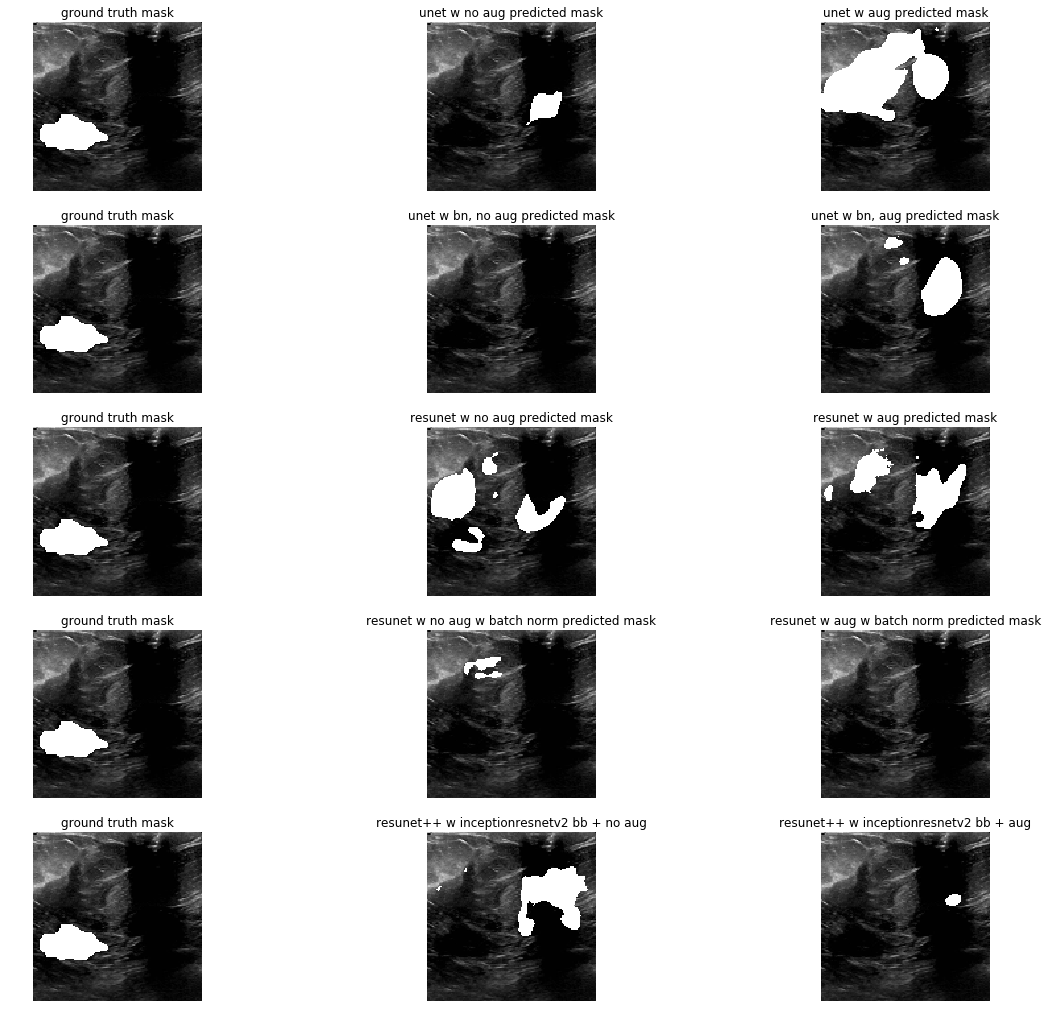

In [7]:
idx = randrange(len(os.listdir(path_to_val_images)))
print(idx)
#base unet
plt.figure(figsize=(20,18))
plt.subplot(5,3,1)
plt.axis('off')
plt.title('ground truth mask')
plt.imshow(overlayed_masks[idx], cmap='gray')

plt.subplot(5,3,2)
plt.axis('off')
plt.title('unet w no aug predicted mask')
plt.imshow(preds[0][idx], cmap='gray')

plt.subplot(5,3,3)
plt.axis('off')
plt.title('unet w aug predicted mask')
plt.imshow(preds[1][idx], cmap='gray')

#unet + batchnorm
plt.subplot(5,3,4)
plt.axis('off')
plt.title('ground truth mask')
plt.imshow(overlayed_masks[idx], cmap='gray')

plt.subplot(5,3,5)
plt.axis('off')
plt.title('unet w bn, no aug predicted mask')
plt.imshow(preds[2][idx], cmap='gray')

plt.subplot(5,3,6)
plt.axis('off')
plt.title('unet w bn, aug predicted mask')
plt.imshow(preds[3][idx], cmap='gray')

#res_unet w out batch norm
plt.subplot(5,3,7)
plt.axis('off')
plt.title('ground truth mask')
plt.imshow(overlayed_masks[idx], cmap='gray')

plt.subplot(5,3,8)
plt.axis('off')
plt.title('resunet w no aug predicted mask')
plt.imshow(preds[4][idx], cmap='gray')

plt.subplot(5,3,9)
plt.axis('off')
plt.title('resunet w aug predicted mask')
plt.imshow(preds[5][idx], cmap='gray')

#res_unet w batch norm
plt.subplot(5,3,10)
plt.axis('off')
plt.title('ground truth mask')
plt.imshow(overlayed_masks[idx], cmap='gray')

plt.subplot(5,3,11)
plt.axis('off')
plt.title('resunet w no aug w batch norm predicted mask')
plt.imshow(preds[6][idx], cmap='gray')

plt.subplot(5,3,12)
plt.axis('off')
plt.title('resunet w aug w batch norm predicted mask')
plt.imshow(preds[7][idx], cmap='gray')

plt.subplot(5,3,13)
plt.axis('off')
plt.title('ground truth mask')
plt.imshow(overlayed_masks[idx], cmap='gray')

plt.subplot(5,3,14)
plt.axis('off')
plt.title('resunet++ w inceptionresnetv2 bb + no aug')
plt.imshow(preds[8][idx], cmap='gray')

plt.subplot(5,3,15)
plt.axis('off')
plt.title('resunet++ w inceptionresnetv2 bb + aug')
plt.imshow(preds[9][idx], cmap='gray')

In [8]:
history0 = h5py.File('models/unet_seg_models/{}_history.hdf5'.format(model_names[0]))
history1 = h5py.File('models/unet_seg_models//{}_history.hdf5'.format(model_names[1]))
history2 = h5py.File('models/unet_seg_models/{}_history.hdf5'.format(model_names[2]))
history3 = h5py.File('models/unet_seg_models/{}_history.hdf5'.format(model_names[3]))
history4 = h5py.File('models/unet_seg_models/{}_history.hdf5'.format(model_names[4]))
history5 = h5py.File('models/unet_seg_models/{}_history.hdf5'.format(model_names[5]))
history6 = h5py.File('models/unet_seg_models/{}_history.hdf5'.format(model_names[6]))
history7 = h5py.File('models/unet_seg_models/{}_history.hdf5'.format(model_names[7]))
history8 = h5py.File('models/unet_seg_models/{}_history.hdf5'.format(model_names[8]))
history9 = h5py.File('models/unet_seg_models/{}_history.hdf5'.format(model_names[9]))

In [9]:
#base unet no aug
train_dice_loss0 = [-i for i in list(history0.get('loss'))]
val_dice_loss0 = [-i for i in list(history0.get('val_loss'))]
train_accuracy0 = list(history0.get('acc'))
val_accuracy0 = list(history0.get('val_acc'))
train_iou0 = list(history0.get('iou'))
val_iou0 = list(history0.get('val_iou'))

#base net + aug
train_dice_loss1 = [-i for i in list(history1.get('loss'))]
val_dice_loss1 = [-i for i in list(history1.get('val_loss'))]
train_accuracy1 = list(history1.get('acc'))
val_accuracy1 = list(history1.get('val_acc'))
train_iou1 = list(history1.get('iou'))
val_iou1 = list(history1.get('val_iou'))

#unet + batchnorm, no aug
train_dice_loss2 = [-i for i in list(history2.get('loss'))]
val_dice_loss2 = [-i for i in list(history2.get('val_loss'))]
train_accuracy2 = list(history2.get('acc'))
val_accuracy2 = list(history2.get('val_acc'))
train_iou2 = list(history2.get('iou'))
val_iou2 = list(history2.get('val_iou'))

#unet + batchnorm + aug
train_dice_loss3 = [-i for i in list(history3.get('loss'))]
val_dice_loss3 = [-i for i in list(history3.get('val_loss'))]
train_accuracy3 = list(history3.get('acc'))
val_accuracy3 = list(history3.get('val_acc'))
train_iou3 = list(history3.get('iou'))
val_iou3 = list(history3.get('val_iou'))

#resunet no aug
train_dice_loss4 = [-i for i in list(history4.get('loss'))]
val_dice_loss4 = [-i for i in list(history4.get('val_loss'))]
train_accuracy4 = list(history4.get('acc'))
val_accuracy4 = list(history4.get('val_acc'))
train_iou4 = list(history4.get('iou'))
val_iou4 = list(history4.get('val_iou'))

#resunet + aug
train_dice_loss5 = [-i for i in list(history5.get('loss'))]
val_dice_loss5 = [-i for i in list(history5.get('val_loss'))]
train_accuracy5 = list(history5.get('acc'))
val_accuracy5 = list(history5.get('val_acc'))
train_iou5 = list(history5.get('iou'))
val_iou5 = list(history5.get('val_iou'))

#resunet + batch norm no aug
train_dice_loss6 = [-i for i in list(history6.get('loss'))]
val_dice_loss6 = [-i for i in list(history6.get('val_loss'))]
train_accuracy6 = list(history6.get('acc'))
val_accuracy6 = list(history6.get('val_acc'))
train_iou6 = list(history6.get('iou'))
val_iou6 = list(history6.get('val_iou'))

#resunet + batch norm + aug
train_dice_loss7 = [-i for i in list(history7.get('loss'))]
val_dice_loss7 = [-i for i in list(history7.get('val_loss'))]
train_accuracy7 = list(history7.get('acc'))
val_accuracy7 = list(history7.get('val_acc'))
train_iou7 = list(history7.get('iou'))
val_iou7 = list(history7.get('val_iou'))

#resunet++ w inceptionresnetv2 bb + no aug
train_dice_loss8 = [-i for i in list(history8.get('loss'))]
val_dice_loss8 = [-i for i in list(history8.get('val_loss'))]
train_accuracy8 = list(history8.get('acc'))
val_accuracy8 = list(history8.get('val_acc'))
train_iou8 = list(history8.get('iou'))
val_iou8 = list(history8.get('val_iou'))

#resunet++ w inceptionresnetv2 bb + aug
train_dice_loss9 = [-i for i in list(history9.get('loss'))]
val_dice_loss9 = [-i for i in list(history9.get('val_loss'))]
train_accuracy9 = list(history9.get('acc'))
val_accuracy9 = list(history9.get('val_acc'))
train_iou9 = list(history9.get('iou'))
val_iou9 = list(history9.get('val_iou'))

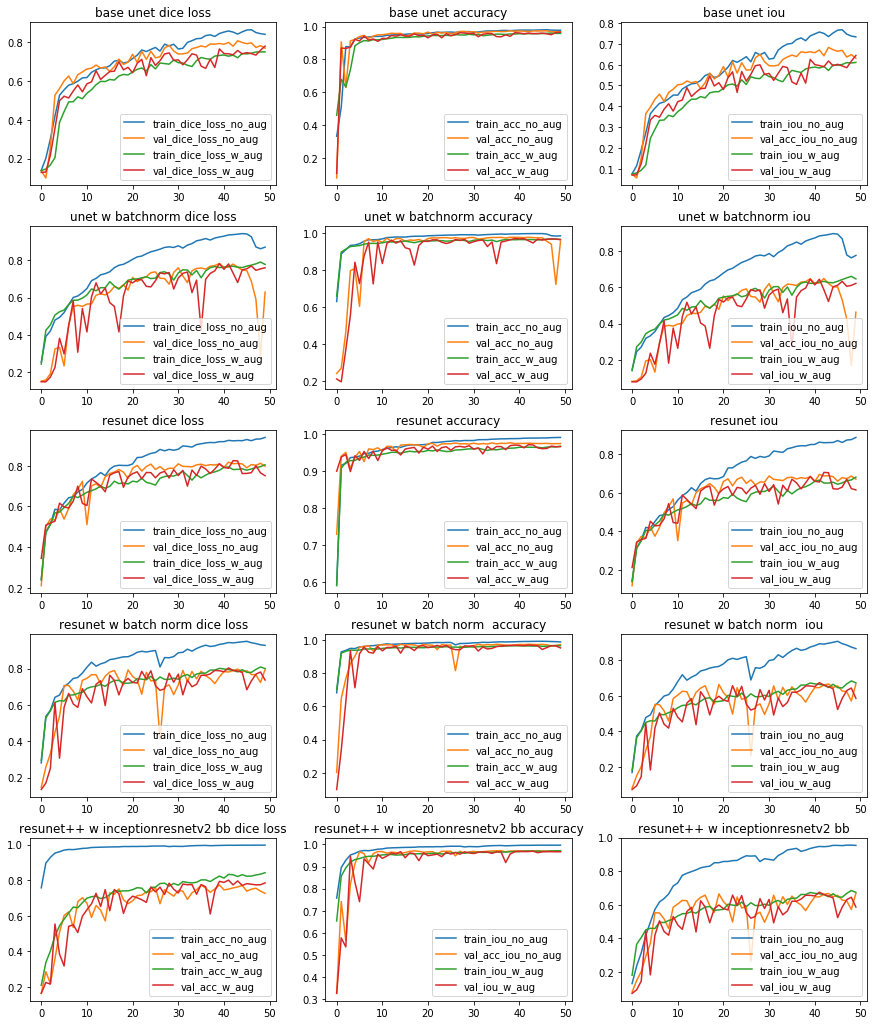

In [10]:
plt.figure(figsize=(15,18))
plt.subplots_adjust(hspace=0.25)

# base unet
plt.subplot(5,3,1)
plt.title('base unet dice loss')
plt.plot(train_dice_loss0,label='train_dice_loss_no_aug')
plt.plot(val_dice_loss0,label='val_dice_loss_no_aug')
plt.plot(train_dice_loss1,label='train_dice_loss_w_aug')
plt.plot(val_dice_loss1,label='val_dice_loss_w_aug')
plt.legend()

plt.subplot(5,3,2)
plt.title('base unet accuracy')
plt.plot(train_accuracy0,label='train_acc_no_aug')
plt.plot(val_accuracy0,label='val_acc_no_aug')
plt.plot(train_accuracy1,label='train_acc_w_aug')
plt.plot(val_accuracy1,label='val_acc_w_aug')
plt.legend()

plt.subplot(5,3,3)
plt.title('base unet iou')
plt.plot(train_iou0,label='train_iou_no_aug')
plt.plot(val_iou0,label='val_acc_iou_no_aug')
plt.plot(train_iou1,label='train_iou_w_aug')
plt.plot(val_iou1,label='val_iou_w_aug')
plt.legend()

# unet w batchnorm
plt.subplot(5,3,4)
plt.title('unet w batchnorm dice loss')
plt.plot(train_dice_loss2,label='train_dice_loss_no_aug')
plt.plot(val_dice_loss2,label='val_dice_loss_no_aug')
plt.plot(train_dice_loss3,label='train_dice_loss_w_aug')
plt.plot(val_dice_loss3,label='val_dice_loss_w_aug')
plt.legend()

plt.subplot(5,3,5)
plt.title('unet w batchnorm accuracy')
plt.plot(train_accuracy2,label='train_acc_no_aug')
plt.plot(val_accuracy2,label='val_acc_no_aug')
plt.plot(train_accuracy3,label='train_acc_w_aug')
plt.plot(val_accuracy3,label='val_acc_w_aug')
plt.legend()

plt.subplot(5,3,6)
plt.title('unet w batchnorm iou')
plt.plot(train_iou2,label='train_iou_no_aug')
plt.plot(val_iou2,label='val_acc_iou_no_aug')
plt.plot(train_iou3,label='train_iou_w_aug')
plt.plot(val_iou3,label='val_iou_w_aug')
plt.legend()

# resunet no batch norm
plt.subplot(5,3,7)
plt.title('resunet dice loss')
plt.plot(train_dice_loss4,label='train_dice_loss_no_aug')
plt.plot(val_dice_loss4,label='val_dice_loss_no_aug')
plt.plot(train_dice_loss5,label='train_dice_loss_w_aug')
plt.plot(val_dice_loss5,label='val_dice_loss_w_aug')
plt.legend()

plt.subplot(5,3,8)
plt.title('resunet accuracy')
plt.plot(train_accuracy4,label='train_acc_no_aug')
plt.plot(val_accuracy4,label='val_acc_no_aug')
plt.plot(train_accuracy5,label='train_acc_w_aug')
plt.plot(val_accuracy5,label='val_acc_w_aug')
plt.legend()

plt.subplot(5,3,9)
plt.title('resunet iou')
plt.plot(train_iou4,label='train_iou_no_aug')
plt.plot(val_iou4,label='val_acc_iou_no_aug')
plt.plot(train_iou5,label='train_iou_w_aug')
plt.plot(val_iou5,label='val_iou_w_aug')
plt.legend()

# resunet no batch norm
plt.subplot(5,3,10)
plt.title('resunet w batch norm dice loss')
plt.plot(train_dice_loss6,label='train_dice_loss_no_aug')
plt.plot(val_dice_loss6,label='val_dice_loss_no_aug')
plt.plot(train_dice_loss7,label='train_dice_loss_w_aug')
plt.plot(val_dice_loss7,label='val_dice_loss_w_aug')
plt.legend()

plt.subplot(5,3,11)
plt.title('resunet w batch norm  accuracy')
plt.plot(train_accuracy6,label='train_acc_no_aug')
plt.plot(val_accuracy6,label='val_acc_no_aug')
plt.plot(train_accuracy7,label='train_acc_w_aug')
plt.plot(val_accuracy7,label='val_acc_w_aug')
plt.legend()

plt.subplot(5,3,12)
plt.title('resunet w batch norm  iou')
plt.plot(train_iou6,label='train_iou_no_aug')
plt.plot(val_iou6,label='val_acc_iou_no_aug')
plt.plot(train_iou7,label='train_iou_w_aug')
plt.plot(val_iou7,label='val_iou_w_aug')
plt.legend()

plt.subplot(5,3,13)
plt.title('resunet++ w inceptionresnetv2 bb dice loss')
plt.plot(train_accuracy8,label='train_acc_no_aug')
plt.plot(val_dice_loss8,label='val_acc_no_aug')
plt.plot(train_dice_loss9,label='train_acc_w_aug')
plt.plot(val_dice_loss9,label='val_acc_w_aug')
plt.legend()

plt.subplot(5,3,14)
plt.title('resunet++ w inceptionresnetv2 bb accuracy')
plt.plot(train_accuracy8,label='train_iou_no_aug')
plt.plot(val_accuracy8,label='val_acc_iou_no_aug')
plt.plot(train_accuracy9,label='train_iou_w_aug')
plt.plot(val_accuracy9,label='val_iou_w_aug')
plt.legend()

plt.subplot(5,3,15)
plt.title('resunet++ w inceptionresnetv2 bb')
plt.plot(train_iou8,label='train_iou_no_aug')
plt.plot(val_iou6,label='val_acc_iou_no_aug')
plt.plot(train_iou7,label='train_iou_w_aug')
plt.plot(val_iou7,label='val_iou_w_aug')
plt.legend()